<a href="https://colab.research.google.com/github/slawomirwojtas/ML-Projects/blob/main/Computer_Vision_Classification_model_comparison_on_FashionMNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model comparison excercise on FashionMNIST dataset

1. Download and prepare the dataset for training
2. Create log file for comparison of different model architecture
3. Functionize repetetive steps
4. Train and test different models
  * Baseline model
  * Baseline model with added non-linearity
  * CNN TinyVGG
  * CNN TinyVGG with different hyperparameters
5. Evaluate the best performing model
6. Save the best model and checks if works correctly after loading

In [28]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as timer
import random
import pandas as pd


# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {device}")

Current device: cuda


## 1. Get and prepare the dataset for training
FashionMnist from torchvision.datasets - https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

### 1.1 Download data

In [29]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [30]:
# Datasets quick check
print("Train data")
print(train_data)
print("\nTest data")
print(test_data)

Train data
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### 1.2 Preview data

In [31]:
# Preview the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [32]:
# Define class names as a list
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [33]:
# Dictionary of classes
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [34]:
# Preview of targets in train data
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [35]:
# Check the shape of an image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

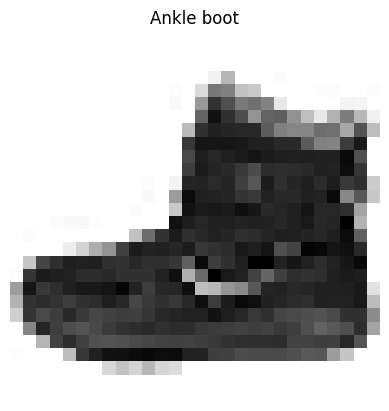

In [36]:
# Visualizing single image
image, label = train_data[0]
print(f"Image shape: {image.shape}")
cmap = plt.colormaps["gray"].reversed()
plt.imshow(image.squeeze(), cmap=cmap)
plt.title(class_names[label])
plt.axis(False)

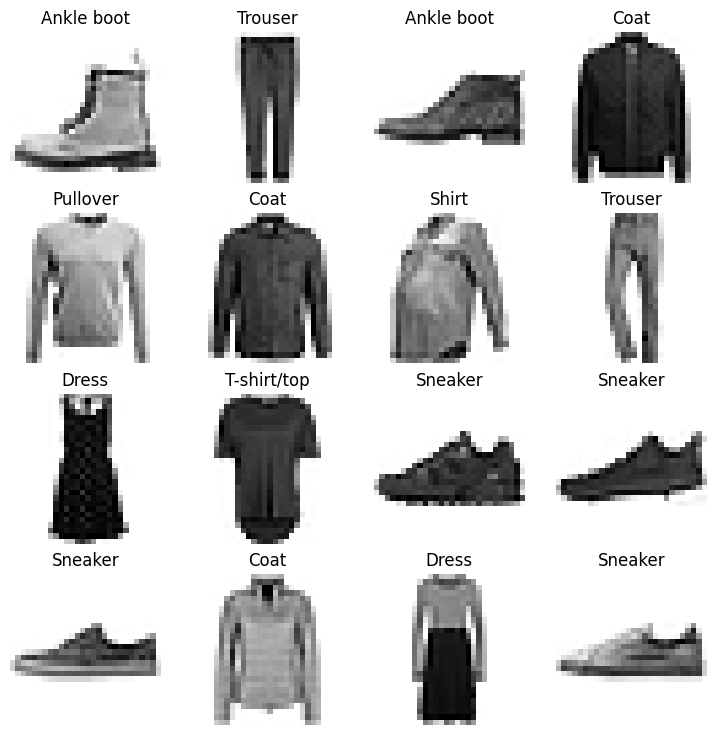

In [37]:
# Visualize random images
#torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
cmap = plt.colormaps["gray"].reversed()
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap=cmap)
  plt.title(class_names[label])
  plt.axis(False)

### 1.3 Prepare DataLoader

In [38]:
# Prepare DataLoader
BATCH_SIZE = 32

# Create iterables from datasets
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"DataLoaders:\n{train_dataloader}\n{test_dataloader}")
print(f"Lenght of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Lenght of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders:
Lenght of train_dataloader: 1875 batches of 32
Lenght of test_dataloader: 313 batches of 32


In [39]:
# Check a single batch from the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 2. Create log file for training results of different models

In [40]:
training_logs = pd.DataFrame(columns=["Model Name",
                                      "Device",
                                      "Batch Size",
                                      "Epochs",
                                      "Learning Rate",
                                      "Loss",
                                      "Accuracy",
                                      "Train Time"])

training_logs

,Model Name,Device,Batch Size,Epochs,Learning Rate,Loss,Accuracy,Train Time


## 3. Functionize training and testing

In [41]:
# Training time measurement
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [42]:
# Train step
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Divide total train loss and accuracy by lenght of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [43]:
# Test step
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0

  # Put model into testing mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate loss (accumatively)
      test_loss += loss_fn(test_pred, y)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

In [54]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Send the data and targets to target device
      X, y = X.to(device), y.to(device)

      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss+= loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale the loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

## 4. Train and test models

### 4.1 Baseline Model

In [45]:
# Create the baseline model
class FashionMNISTV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [46]:
# Find out input_shape for the first linear layer

# Create a flattern layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
print(f"Sample shape before flattening: {x.shape} -> [color_channels, height, width]")

# Flatten the sample
output = flatten_model(x) # perform forward pass
print(f"Sample shape after flattening: {output.shape}  -> [color_channels, height*width]")

Sample shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Sample shape after flattening: torch.Size([1, 784])  -> [color_channels, height*width]


In [47]:
# Initialize model with input parameters and put to device
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = FashionMNISTV0(
    input_shape=784, # this is 28*28 (image size after flattening)
    hidden_units=10,
    output_shape=len(class_names) # one for every class
).to(device)

model_0

FashionMNISTV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [50]:
# Preview the model output
dummy_x = torch.rand([1, 1, 28, 28]).to(device) # dummy dataloader
model_0(dummy_x) # output is one logit per class

tensor([[-0.1747,  0.2848,  0.0754, -0.1747,  0.4594,  0.1398,  0.4141,  0.2572,
         -0.2044, -0.0451]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [51]:
# Setup loss function, accuracy function and optimizer
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

LEARNING_RATE = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=LEARNING_RATE)

In [55]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0_train_start = timer()

# Set epochs
epochs = 3

# Train and test model
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

model_0_train_end = timer()
model_0_train_total_time = print_train_time(start=model_0_train_start,
                                            end=model_0_train_end,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.44395 | Train acc: 84.43%
Test loss: 0.46506, Test acc: 83.65%

Epoch: 1
----------
Train loss: 0.43662 | Train acc: 84.82%
Test loss: 0.46453, Test acc: 83.89%

Epoch: 2
----------
Train loss: 0.43045 | Train acc: 84.88%
Test loss: 0.46594, Test acc: 83.93%

Train time on cuda:0: 32.072 seconds


In [56]:
# Calculate model results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV0',
 'model_loss': 0.46593597531318665,
 'model_acc': 83.92571884984025}

In [57]:
# Collect training results for model
results_model_0 = [model_0_results["model_name"], device, BATCH_SIZE, epochs, LEARNING_RATE, model_0_results["model_loss"], model_0_results["model_acc"], model_0_train_total_time]
training_logs.loc[len(training_logs)] = results_model_0
training_logs.drop_duplicates(inplace=True)
training_logs

,Model Name,Device,Batch Size,Epochs,Learning Rate,Loss,Accuracy,Train Time
0,FashionMNISTV0,cuda,32,3,0.1,0.465936,83.925719,32.072407


### 4.2 Baseline Model with added non-linearity

In [58]:
# Create the baseline model with non-linearity
class FashionMNISTV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [59]:
# Initialize model with input parameters and put to device
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = FashionMNISTV1(
    input_shape=784, # this is 28*28 (image size after flattening)
    hidden_units=10,
    output_shape=len(class_names) # one for every class
).to(device)

model_1

FashionMNISTV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [60]:
# Setup loss function, accuracy function and optimizer
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

LEARNING_RATE = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=LEARNING_RATE)

In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1_train_start = timer()

# Set epochs
epochs = 3

# Train and test model
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

model_1_train_end = timer()
model_1_train_total_time = print_train_time(start=model_1_train_start,
                                            end=model_1_train_end,
                                            device=str(next(model_1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.64607 | Train acc: 77.17%
Test loss: 0.53855, Test acc: 80.76%

Epoch: 1
----------
Train loss: 0.48094 | Train acc: 82.94%
Test loss: 0.49390, Test acc: 82.46%

Epoch: 2
----------
Train loss: 0.44689 | Train acc: 84.16%
Test loss: 0.45746, Test acc: 83.99%

Train time on cuda:0: 32.370 seconds


In [62]:
# Calculate model results on test dataset
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.45746350288391113,
 'model_acc': 83.98562300319489}

In [63]:
# Collect training results for model
results_model_1 = [model_1_results["model_name"], device, BATCH_SIZE, epochs, LEARNING_RATE, model_1_results["model_loss"], model_1_results["model_acc"], model_1_train_total_time]
training_logs.loc[len(training_logs)] = results_model_1
training_logs.drop_duplicates(inplace=True)
training_logs

,Model Name,Device,Batch Size,Epochs,Learning Rate,Loss,Accuracy,Train Time
0,FashionMNISTV0,cuda,32,3,0.1,0.465936,83.925719,32.072407
1,FashionMNISTV1,cuda,32,3,0.1,0.457464,83.985623,32.370336


### 4.3 CNN TinyVGG Model

In [64]:
# Create a convolutional neural network
class FashionMNISTV2(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x

In [65]:
# Instantiate the model and put on device
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = FashionMNISTV2(input_shape=1, # number of color channels
                         hidden_units=10,
                         output_shape=len(class_names)).to(device)
model_2

FashionMNISTV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [66]:
# Test model on dummy data to find out linear layer in_features value
rand_image_tensor = torch.randn(size=(1, 28, 28)).to(device)
rand_image_dataloader = rand_image_tensor.unsqueeze(dim=0)
rand_image_dataloader.shape

torch.Size([1, 1, 28, 28])

In [67]:
# Check for size mismatch (uncomment prints in the forward method of the model)
model_2(rand_image_dataloader)

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [68]:
# Setup loss function, accuracy function and optimizer
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

LEARNING_RATE = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=LEARNING_RATE)

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2_train_start = timer()

# Set epochs
epochs = 3

# Train and test model
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

model_2_train_end = timer()
model_2_train_total_time = print_train_time(start=model_2_train_start,
                                            end=model_2_train_end,
                                            device=str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.59288 | Train acc: 78.56%
Test loss: 0.39235, Test acc: 85.99%

Epoch: 1
----------
Train loss: 0.36533 | Train acc: 86.91%
Test loss: 0.35224, Test acc: 86.84%

Epoch: 2
----------
Train loss: 0.32631 | Train acc: 88.21%
Test loss: 0.32102, Test acc: 87.99%

Train time on cuda:0: 42.561 seconds


In [70]:
# Calculate model results on test dataset
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3210243582725525,
 'model_acc': 87.98921725239616}

In [71]:
# Collect training results for model
results_model_2 = [model_2_results["model_name"], device, BATCH_SIZE, epochs, LEARNING_RATE, model_2_results["model_loss"], model_2_results["model_acc"], model_2_train_total_time]
training_logs.loc[len(training_logs)] = results_model_2
training_logs.drop_duplicates(inplace=True)
training_logs

,Model Name,Device,Batch Size,Epochs,Learning Rate,Loss,Accuracy,Train Time
0,FashionMNISTV0,cuda,32,3,0.1,0.465936,83.925719,32.072407
1,FashionMNISTV1,cuda,32,3,0.1,0.457464,83.985623,32.370336
2,FashionMNISTV2,cuda,32,3,0.1,0.321024,87.989217,42.560505


### 4.4 CNN TinyVGG with different hyperparameters

In [72]:
# Modify TinyVGG model
class FashionMNISTV3(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=2,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=2,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*8*8,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x

In [73]:
# Instantiate the model and put on device
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_3 = FashionMNISTV3(input_shape=1, # number of color channels
                         hidden_units=15,
                         output_shape=len(class_names)).to(device)
model_3

FashionMNISTV3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=960, out_features=10, bias=True)
  )
)

In [74]:
# Test model on dummy data to find out linear layer in_features value
rand_image_tensor = torch.randn(size=(1, 28, 28)).to(device)
rand_image_dataloader = rand_image_tensor.unsqueeze(dim=0)
rand_image_dataloader.shape

torch.Size([1, 1, 28, 28])

In [75]:
# Check for size mismatch (uncomment prints in the forward method of the model)
model_3(rand_image_dataloader)

tensor([[-0.0193,  0.0256,  0.0431,  0.0068, -0.0354, -0.0072,  0.0337, -0.0931,
          0.0198,  0.0281]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [76]:
# Setup loss function, accuracy function and optimizer
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

LEARNING_RATE = 0.05

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=LEARNING_RATE)

In [77]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3_train_start = timer()

# Set epochs
epochs = 3

# Train and test model
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_3,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_3,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

model_3_train_end = timer()
model_3_train_total_time = print_train_time(start=model_3_train_start,
                                            end=model_3_train_end,
                                            device=str(next(model_3.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.69097 | Train acc: 75.13%
Test loss: 0.41116, Test acc: 85.74%

Epoch: 1
----------
Train loss: 0.37800 | Train acc: 86.42%
Test loss: 0.35268, Test acc: 87.52%

Epoch: 2
----------
Train loss: 0.33268 | Train acc: 88.14%
Test loss: 0.32850, Test acc: 88.20%

Train time on cuda:0: 39.945 seconds


In [78]:
# Calculate model results on test dataset
model_3_results = eval_model(model=model_3,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_3_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV3',
 'model_loss': 0.32850009202957153,
 'model_acc': 88.19888178913737}

In [79]:
# Collect training results for model
results_model_3 = [model_3_results["model_name"], device, BATCH_SIZE, epochs, LEARNING_RATE, model_3_results["model_loss"], model_3_results["model_acc"], model_3_train_total_time]
training_logs.loc[len(training_logs)] = results_model_3
training_logs.drop_duplicates(inplace=True)
training_logs

,Model Name,Device,Batch Size,Epochs,Learning Rate,Loss,Accuracy,Train Time
0,FashionMNISTV0,cuda,32,3,0.10,0.465936,83.925719,32.072407
1,FashionMNISTV1,cuda,32,3,0.10,0.457464,83.985623,32.370336
2,FashionMNISTV2,cuda,32,3,0.10,0.321024,87.989217,42.560505
3,FashionMNISTV3,cuda,32,3,0.05,0.328500,88.198882,39.944876


## 5. Evaluate the best performing model

### 5.1 Visualize random predictions

In [80]:
# Create lists with random samples from test data
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9): # random 9 samples from test_data
  test_samples.append(sample)
  test_labels.append(label)

# Check the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

In [81]:
# Functionize making predictions for images (non-batch)
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (unsqueeze to add batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [82]:
# Make predictions
pred_probs = make_predictions(model=model_3,
                              data=test_samples,
                              device=device)

pred_probs[0]

tensor([2.3428e-03, 1.1434e-04, 6.1761e-02, 3.5840e-05, 8.1627e-01, 4.0883e-05,
        1.1879e-01, 2.3621e-07, 6.2966e-04, 1.7126e-05])

In [83]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 6, 0, 5, 8, 2, 4, 0, 4])

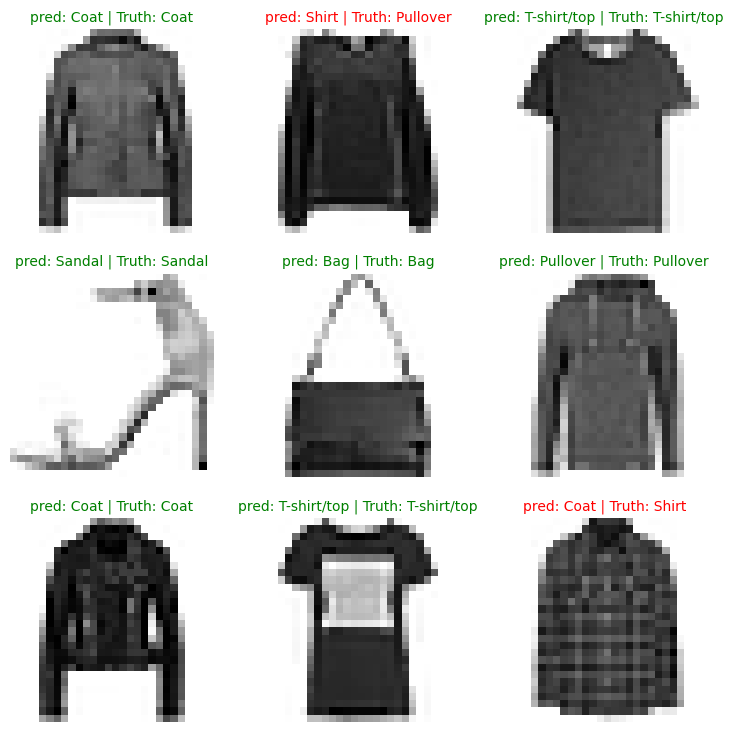

In [84]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
cmap = plt.colormaps["gray"]
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap=cmap.reversed())

  # Find the prediction
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

### 5.2 Evaluate the model over the whole test data

In [85]:
# See if required packages are installed and if not, install them
try:
  import torchmetrics, mlxtend
  #print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
print(f"torchmetrics version: {torchmetrics.__version__}")
print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0
torchmetrics version: 1.2.0
mlxtend version: 0.23.0


In [86]:
# Make predictions on test_dataloader
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put preditions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([5, 2, 1, 1, 6, 1, 4, 6, 5, 7])

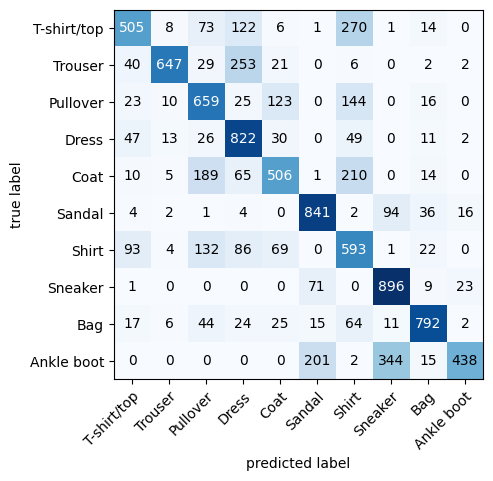

In [87]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names
                                )

## 6. Save the model and verify if loads correctly

In [88]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "FashionMNIST_classification_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_3.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models/FashionMNIST_classification_model.pth


In [89]:
# Create a new instance
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loaded_model_3 = FashionMNISTV3(input_shape=1,
                                hidden_units=15,
                                output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_3.to(device)

FashionMNISTV3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=960, out_features=10, bias=True)
  )
)

In [90]:
# Original model
pred_probs = make_predictions(model=model_3,
                              data=test_samples,
                              device=device)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 6, 0, 5, 8, 2, 4, 0, 4])

In [91]:
# Original model
loaded_pred_probs = make_predictions(model=loaded_model_3,
                                     data=test_samples,
                                     device=device)
loaded_pred_classes = pred_probs.argmax(dim=1)
loaded_pred_classes

tensor([4, 6, 0, 5, 8, 2, 4, 0, 4])